In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
train_metadata = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_metadata = torchvision.datasets.MNIST(root='./data', train=False, download=True)

train_x = train_metadata.data[:50000].unsqueeze(1) / 255
val_x = train_metadata.data[-10000:].unsqueeze(1) / 255
test_x = test_metadata.data.unsqueeze(1) / 255
train_y = train_metadata.targets[:50000]
val_y = train_metadata.targets[-10000:]
test_y = test_metadata.targets

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 256
NUM_TRAIN = 50000
NUM_VAL = 10000
IMG_C = train_x.shape[-3]
IMG_H = train_x.shape[-2]
IMG_W = train_x.shape[-1]

train_data = TensorDataset(train_x, train_y)
val_data = TensorDataset(val_x, val_y)
test_data = TensorDataset(test_x, test_y)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
          nn.Conv2d(input_dim, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dim)
        self.fc_var = nn.Linear(128 * 3 * 3, latent_dim)

    def forward(self, x):
        encoded = self.encode(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_var(encoded)
        z = self.reparameterization(mu, log_var)
        return z, mu, log_var

    def reparameterization(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std).to(DEVICE)
        z = mu + std * epsilon
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, output_dim, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.Flatten()
        )
        self.fc_alpha = nn.Linear(31 * 31, IMG_H * IMG_W)
        self.fc_beta = nn.Linear(31 * 31, IMG_H * IMG_W)

    def forward(self, x):
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.decode(x)
        alpha = F.softplus(self.fc_alpha(x))
        beta = F.softplus(self.fc_beta(x))
        return alpha, beta

class VAE(nn.Module):
    def __init__(self, encoder, decoder, var=0.5):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.var = var

    def forward(self, x):
        z, mu_z, log_var_z = self.encoder(x)
        alpha_x, beta_x = self.decoder(z)
        return mu_z, log_var_z, alpha_x, beta_x

    def reconstruct(self, alpha_x, beta_x):
        beta_dist = torch.distributions.Beta(alpha_x, beta_x)
        x_recon = beta_dist.sample()
        return x_recon.view(x_recon.shape[0], IMG_C, IMG_H, IMG_W)

In [5]:
LATENT_DIM = 16

encoder = Encoder(input_dim=IMG_C, latent_dim=LATENT_DIM)
decoder = Decoder(latent_dim=LATENT_DIM, output_dim=IMG_C)
vae = VAE(encoder, decoder).to(DEVICE)
print(vae)

VAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (fc_mu): Linear(in_features=1152, out_features=16, bias=True)
    (fc_var): Linear(in_features=1152, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (decode): Sequential(
      (0): ConvTranspose2d(16, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentu

  5%|▌         | 1/20 [00:07<02:26,  7.72s/it]

Epoch 1, Mean Training ELBO -7757.76648625, Mean Validation ELBO -7849.54690859375


 10%|█         | 2/20 [00:13<02:00,  6.68s/it]

Epoch 2, Mean Training ELBO -7865.8327725, Mean Validation ELBO -7901.183825


 15%|█▌        | 3/20 [00:19<01:48,  6.37s/it]

Epoch 3, Mean Training ELBO -7932.04708, Mean Validation ELBO -7967.96738515625


 20%|██        | 4/20 [00:25<01:39,  6.22s/it]

Epoch 4, Mean Training ELBO -7986.41294625, Mean Validation ELBO -8005.7386921875


 25%|██▌       | 5/20 [00:31<01:32,  6.16s/it]

Epoch 5, Mean Training ELBO -8018.75381125, Mean Validation ELBO -8032.8788125


 30%|███       | 6/20 [00:37<01:25,  6.12s/it]

Epoch 6, Mean Training ELBO -8043.05947, Mean Validation ELBO -8042.907240625


 35%|███▌      | 7/20 [00:43<01:19,  6.11s/it]

Epoch 7, Mean Training ELBO -8059.78796, Mean Validation ELBO -8060.6961921875


 40%|████      | 8/20 [00:49<01:13,  6.10s/it]

Epoch 8, Mean Training ELBO -8073.1311125, Mean Validation ELBO -8079.16363359375


 45%|████▌     | 9/20 [00:56<01:07,  6.09s/it]

Epoch 9, Mean Training ELBO -8086.50007875, Mean Validation ELBO -8078.14844375


 50%|█████     | 10/20 [01:02<01:00,  6.09s/it]

Epoch 10, Mean Training ELBO -8094.19256375, Mean Validation ELBO -8092.12805234375


 55%|█████▌    | 11/20 [01:08<00:54,  6.08s/it]

Epoch 11, Mean Training ELBO -8105.67456125, Mean Validation ELBO -8102.21712734375


 60%|██████    | 12/20 [01:14<00:48,  6.08s/it]

Epoch 12, Mean Training ELBO -8112.87043625, Mean Validation ELBO -8108.3073765625


 65%|██████▌   | 13/20 [01:20<00:42,  6.07s/it]

Epoch 13, Mean Training ELBO -8121.3661825, Mean Validation ELBO -8116.9895015625


 70%|███████   | 14/20 [01:26<00:36,  6.08s/it]

Epoch 14, Mean Training ELBO -8129.03544375, Mean Validation ELBO -8129.42480546875


 75%|███████▌  | 15/20 [01:32<00:30,  6.08s/it]

Epoch 15, Mean Training ELBO -8136.3501175, Mean Validation ELBO -8132.100365625


 80%|████████  | 16/20 [01:38<00:24,  6.09s/it]

Epoch 16, Mean Training ELBO -8141.690125, Mean Validation ELBO -8141.52687109375


 85%|████████▌ | 17/20 [01:44<00:18,  6.09s/it]

Epoch 17, Mean Training ELBO -8151.53204125, Mean Validation ELBO -8142.4230671875


 90%|█████████ | 18/20 [01:50<00:12,  6.08s/it]

Epoch 18, Mean Training ELBO -8156.91499875, Mean Validation ELBO -8144.5547046875


 95%|█████████▌| 19/20 [01:56<00:06,  6.08s/it]

Epoch 19, Mean Training ELBO -8160.90162625, Mean Validation ELBO -8151.321015625


100%|██████████| 20/20 [02:02<00:00,  6.14s/it]

Epoch 20, Mean Training ELBO -8164.88714, Mean Validation ELBO -8161.47650546875


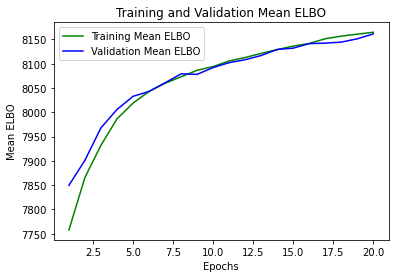

In [6]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def train_vae(num_epochs, patience=5):
    train_elbos = []
    val_elbos = []
    best_val_elbo = np.inf
    tolerance = 0
    epochs = num_epochs
    for epoch in tqdm(range(num_epochs)):
        overall_train_elbo = 0.0
        overall_val_elbo = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            x, _ = batch
            x = x.to(DEVICE)
            mu_z, log_var_z, alpha_x, beta_x = vae(x)
            x = torch.flatten(x, start_dim=1)
            log_p = torch.sum((alpha_x - 1) * torch.log(x + 1e-7) + (beta_x - 1) * torch.log(1 - x + 1e-7) -
                              torch.lgamma(alpha_x) - torch.lgamma(beta_x) + torch.lgamma(alpha_x + beta_x))
            kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
            negative_elbo = -log_p + kl
            negative_elbo.backward()
            optimizer.step()
            overall_train_elbo += negative_elbo.item()

        for batch in val_dataloader:
            x, _ = batch
            x = x.to(DEVICE)
            with torch.no_grad():
                mu_z, log_var_z, alpha_x, beta_x = vae(x)
                x = torch.flatten(x, start_dim=1)
                log_p = torch.sum((alpha_x - 1) * torch.log(x + 1e-7) + (beta_x - 1) * torch.log(1 - x + 1e-7) -
                              torch.lgamma(alpha_x) - torch.lgamma(beta_x) + torch.lgamma(alpha_x + beta_x))
                kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
                negative_elbo = -log_p + kl
                overall_val_elbo += negative_elbo.item()
        mean_train_elbo = overall_train_elbo / NUM_TRAIN
        mean_val_elbo = overall_val_elbo / NUM_VAL
        print('Epoch {}, Mean Training ELBO {}, Mean Validation ELBO {}'.format(epoch + 1, mean_train_elbo, mean_val_elbo))
        train_elbos.append(-mean_train_elbo)
        val_elbos.append(-mean_val_elbo)
        if mean_val_elbo < best_val_elbo:
            best_val_elbo = mean_val_elbo
            tolerance = 0
        else:
            tolerance += 1
            if tolerance == patience:
                print('Early Stopped!')
                epochs = epoch + 1
                break
    plt.plot(range(1, epochs + 1), train_elbos, 'g', label='Training Mean ELBO')
    plt.plot(range(1, epochs + 1), val_elbos, 'b', label='Validation Mean ELBO')
    plt.title('Training and Validation Mean ELBO')
    plt.xlabel('Epochs')
    plt.ylabel('Mean ELBO')
    plt.legend()
    plt.savefig('elbo_2b')
    plt.show()
train_vae(num_epochs=20)

In [8]:
torch.save(vae.state_dict(), 'state_dict_t2b.pt')

In [9]:
def test_vae():
    x, _ = next(iter(test_dataloader))
    x = x.to(DEVICE)
    with torch.no_grad():
        _, _, alpha_x, beta_x = vae(x)
        x_recon = vae.reconstruct(alpha_x, beta_x)
        return x, x_recon
test_batch, test_batch_recon = test_vae()

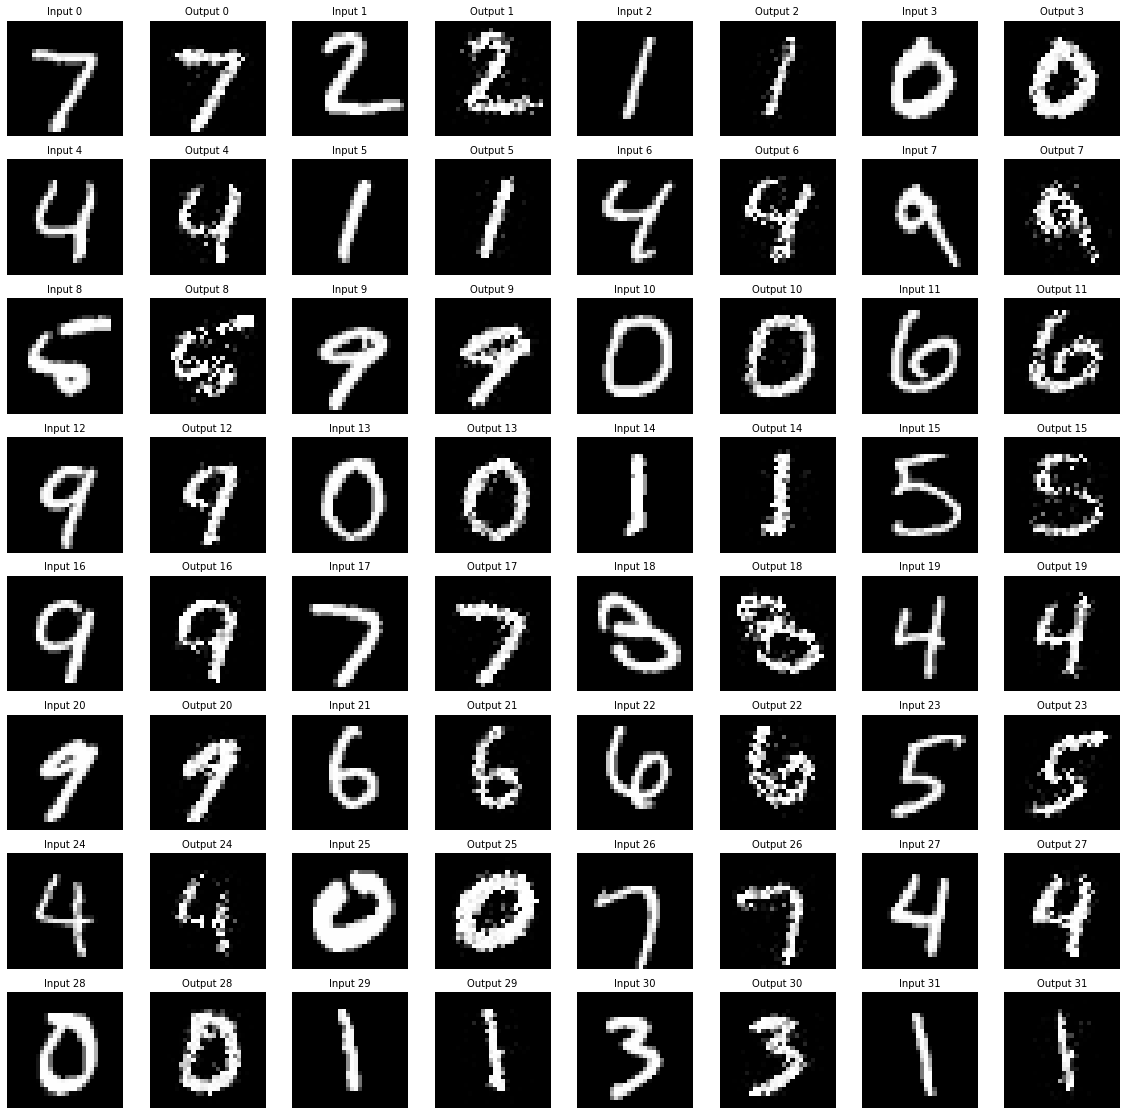

In [10]:
def show_images(x, x_recon):
    """ plots first 32 images and reconstructions"""
    x = x.view(x.shape[0], 28, 28)
    x_recon = x_recon.view(x_recon.shape[0], 28, 28)
    fig, ax = plt.subplots(8, 8, figsize=(20, 20))
    for i in range(8):
        for j in range(4):
            ax[i][2*j].imshow(x[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j+1].imshow(x_recon[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j].set_title(f"Input {i*4+j}", fontsize=10)
            ax[i][2*j+1].set_title(f"Output {i*4+j}", fontsize=10)
            ax[i][2*j].axis('off')
            ax[i][2*j+1].axis('off')
    plt.savefig('reconstructions_2b.png')
show_images(test_batch, test_batch_recon)

In [13]:
def sample_images(num_samples):
    with torch.no_grad():
        z = torch.randn((num_samples, LATENT_DIM)).to(DEVICE)
        alpha_x, beta_x = decoder(z)
        x_samples = vae.reconstruct(alpha_x, beta_x)
        return x_samples
samples = sample_images(num_samples=16)

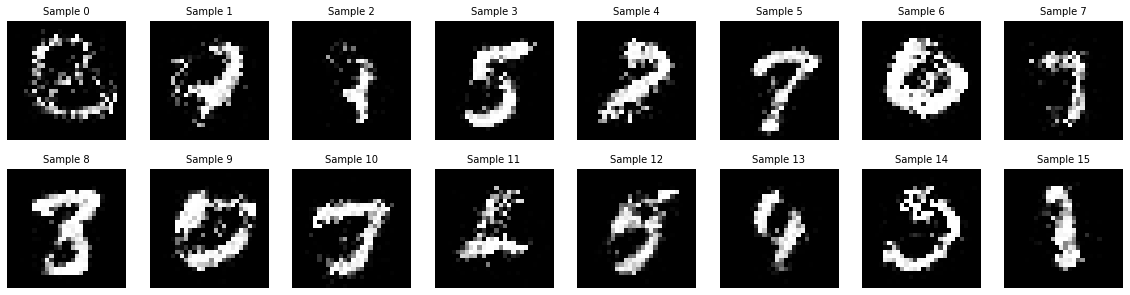

In [14]:
def show_samples(x):
    x = x.view(x.shape[0], 28, 28)
    fig, ax = plt.subplots(2, 8, figsize=(20, 5))
    for i in range(2):
        for j in range(8):
            ax[i][j].imshow(x[i*8+j].cpu().numpy(), cmap="Greys_r")
            ax[i][j].set_title(f"Sample {i*8+j}", fontsize=10)
            ax[i][j].axis('off')
    plt.savefig('samples_2b.png')
show_samples(samples)